## Smoking model

Value iteration converged after 194 iterations.


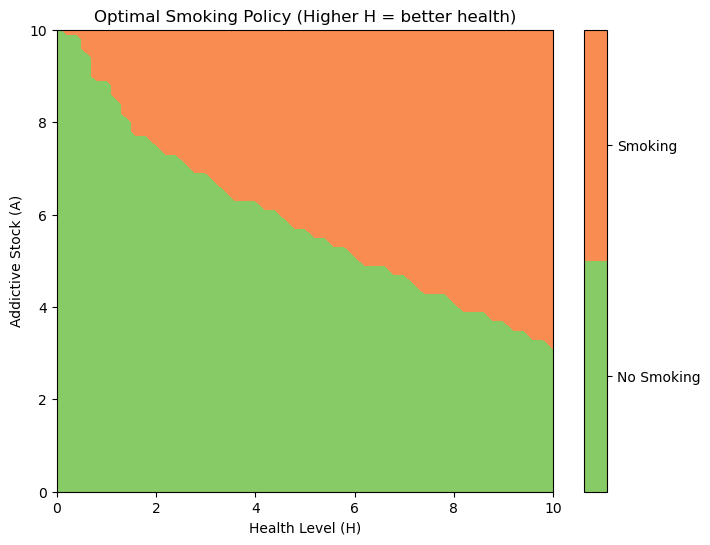

In [14]:
import numpy as np
import matplotlib.pyplot as plt

u = 2.0           # Baseline enjoyment from smoking
theta = 0.02      # Reinforcement effect weight (quadratic in A)
phi = 0.95        # Retention rate of addiction
beta = 0.1        # Increase in addiction when smoking
eta = 0.9         # Base health depreciation per period (if not smoking)
gamma = 0.2       # Additional health depreciation from smoking
delta = 0.95      # Discount factor
cost_smoking = 2.0  # Explicit monetary cost of smoking
mu = 0.5

# Health utility function: higher H gives more utility.
def health_utility(H):
    # For example, we might assume utility is concave in health.
    return mu * H**(1/2)

# Grids for state variables:
A_min, A_max, A_steps = 0, 10, 51  # addiction
H_min, H_max, H_steps = 0, 10, 51    # health level (higher is better)
A_grid = np.linspace(A_min, A_max, A_steps)
H_grid = np.linspace(H_min, H_max, H_steps)

# Initialize value function and policy
V = np.zeros((A_steps, H_steps))
policy = np.zeros((A_steps, H_steps), dtype=int)  # 0: no smoking, 1: smoking

tol = 1e-4
max_iter = 1000

def find_nearest_index(x, grid):
    return np.abs(grid - x).argmin()
A_mesh, H_mesh = np.meshgrid(A_grid, H_grid, indexing='ij')


# Value iteration: here, the immediate utility depends on current health.
for iteration in range(max_iter):
    V_new = np.copy(V)
    diff = 0.0
    for i, A in enumerate(A_grid):
        for j, H in enumerate(H_grid):
            value_actions = np.zeros(2)
            
            # Action 0: Not smoking
            # Immediate utility: utility from current health.
            immediate_0 = health_utility(H)
            # Transition: addiction decays; health depreciates at base rate.
            A_next_0 = phi * A
            H_next_1 = H * eta  # ensure health doesn't drop below 0
            i_next_0 = find_nearest_index(A_next_0, A_grid)
            j_next_0 = find_nearest_index(H_next_0, H_grid)
            continuation_0 = V[i_next_0, j_next_0]
            value_actions[0] = immediate_0 + delta * continuation_0
            
            # Action 1: Smoking
            # Immediate utility: enjoyment from smoking plus current health utility,
            # minus explicit monetary cost.
            # You could also include a reinforcement term; for instance, theta * A or theta * A^2.
            immediate_1 = u + theta * A**2 + health_utility(H) - cost_smoking
            # Transition: addiction increases; health deteriorates faster.
            A_next_1 = A  
            H_next_1 = H * (eta - gamma)
            i_next_1 = find_nearest_index(A_next_1, A_grid)
            j_next_1 = find_nearest_index(H_next_1, H_grid)
            continuation_1 = V[i_next_1, j_next_1]
            value_actions[1] = immediate_1 + delta * continuation_1
            
            best_action = np.argmax(value_actions)
            V_new[i, j] = value_actions[best_action]
            policy[i, j] = best_action
            
            diff = max(diff, np.abs(V_new[i, j] - V[i, j]))
    V = V_new
    if diff < tol:
        print(f"Value iteration converged after {iteration+1} iterations.")
        break
else:
    print("Value iteration did not converge.")

# Plot the optimal policy: 0: No Smoking, 1: Smoking
plt.figure(figsize=(8,6))
plt.contourf(H_mesh, A_mesh, policy, levels=[-0.5,0.5,1.5], cmap='RdYlGn_r')
cbar = plt.colorbar(ticks=[0, 1])
cbar.ax.set_yticklabels(['No Smoking','Smoking'])
plt.xlabel('Health Level (H)')
plt.ylabel('Addictive Stock (A)')
plt.title('Optimal Smoking Policy (Higher H = better health)')
plt.show()


At t=0, state (A=2, H=9): Optimal decision = 0
At t=0, state (A=5, H=2): Optimal decision = 0


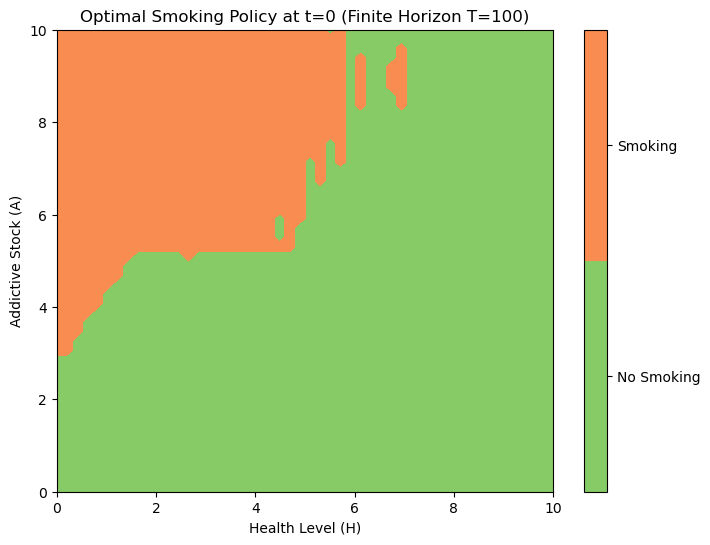

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# PARAMETERS
# -----------------------------
T = 100                # Finite horizon (T=100 periods)
u = 0.0                # Baseline enjoyment from smoking
theta = 0.5        # Reinforcement effect weight (quadratic in A)
phi_0 = 0.98           # Retention rate of addiction (no smoke)
phi_1 = 1.02           # Retention rate of addiction (smoke)
eta = 0.95             # Base health depreciation per period (if not smoking)
gamma = 0.25           # Additional health depreciation from smoking
beta = 0.90           # Discount factor
cost_smoking = 1.5     # Explicit monetary cost of smoking
mu = 1.0               # Scale factor for health utility

# Health utility function: we use square-root utility (concave) so that low H is heavily penalized.
def health_utility(H):
    # To avoid issues with H=0, we assume H is always at least 0.
    return mu * H

# -----------------------------
# STATE SPACE DISCRETIZATION
# -----------------------------
# We assume H > 0 for health utility. We define H from 0 to 10 and A from 0 to 10.
A_min, A_max, A_steps = 0, 10, 50  # addiction grid: 0, 0.2, ..., 10
H_min, H_max, H_steps = 0, 10, 50    # health grid: 0, 0.2, ..., 10
A_grid = np.linspace(A_min, A_max, A_steps)
H_grid = np.linspace(H_min, H_max, H_steps)
A_mesh, H_mesh = np.meshgrid(A_grid, H_grid, indexing='ij')

# -----------------------------
# VALUE FUNCTION & POLICY INITIALIZATION (Finite Horizon)
# -----------------------------
# We define V[t, i, j] for t=0,...,T, where t=T is the terminal period.
V = np.zeros((T+1, A_steps, H_steps))
policy = np.zeros((T, A_steps, H_steps), dtype=int)  # policy only defined for periods 0,...,T-1

for i in range(A_steps):
    for j in range(H_steps):
        A_val = A_grid[i]
        H_val = H_grid[j]
        V[T, i, j] = max(u + theta * A_val + health_utility(H_val) - cost_smoking,
                          health_utility(H_val))

def find_nearest_index(x, grid):
    return np.abs(grid - x).argmin()

# -----------------------------
# BACKWARD INDUCTION (Value Iteration)
# -----------------------------
for t in range(T-1, -1, -1):
    for i, A in enumerate(A_grid):
        for j, H in enumerate(H_grid):
            # Ensure H is nonnegative
            H_current = max(H, 0)
            value_actions = np.zeros(2)
            
            # Action 0: Not smoking
            immediate_0 = health_utility(H_current)
            A_next_0 = phi_0 * A
            H_next_0 = H_current * eta  # additive health decline
            H_next_0 = max(H_next_0, 0)   # ensure health doesn't go below 0
            i_next_0 = find_nearest_index(A_next_0, A_grid)
            j_next_0 = find_nearest_index(H_next_0, H_grid)
            continuation_0 = V[t+1, i_next_0, j_next_0]
            value_actions[0] = immediate_0 + beta * continuation_0
            
            # Action 1: Smoking
            immediate_1 = u + theta * A + health_utility(H_current) - cost_smoking
            # For smoking, you might want addiction to increase; here we update as:
            A_next_1 = phi_1 * A 
            H_next_1 = H_current * (eta - gamma)
            H_next_1 = max(H_next_1, 0)
            i_next_1 = find_nearest_index(A_next_1, A_grid)
            j_next_1 = find_nearest_index(H_next_1, H_grid)
            continuation_1 = V[t+1, i_next_1, j_next_1]
            value_actions[1] = immediate_1 + beta * continuation_1
            
            best_action = np.argmax(value_actions)
            V[t, i, j] = value_actions[best_action]
            policy[t, i, j] = best_action

# -----------------------------
# EXAMPLE: LOOK UP THE OPTIMAL DECISION AT SPECIFIC STATES AT t=0
# -----------------------------
state1_A, state1_H = 2, 9  # Moderate addiction, good health
state2_A, state2_H = 5, 2  # Higher addiction, low health

i_state1 = find_nearest_index(state1_A, A_grid)
j_state1 = find_nearest_index(state1_H, H_grid)
i_state2 = find_nearest_index(state2_A, A_grid)
j_state2 = find_nearest_index(state2_H, H_grid)

print("At t=0, state (A=2, H=9): Optimal decision =", policy[0, i_state1, j_state1])
print("At t=0, state (A=5, H=2): Optimal decision =", policy[0, i_state2, j_state2])

# -----------------------------
# PLOTTING THE OPTIMAL POLICY AT t=0
# -----------------------------
plt.figure(figsize=(8,6))
plt.contourf(H_mesh, A_mesh, policy[0], levels=[-0.5, 0.5, 1.5], cmap='RdYlGn_r')
cbar = plt.colorbar(ticks=[0, 1])
cbar.ax.set_yticklabels(['No Smoking', 'Smoking'])
plt.xlabel('Health Level (H)')
plt.ylabel('Addictive Stock (A)')
plt.title('Optimal Smoking Policy at t=0 (Finite Horizon T=100)')
plt.show()